# Notes Agent

## Setting up llm

In [4]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

In [5]:
load_dotenv()

True

In [6]:
llm = ChatOpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"), model="gpt-3.5-turbo")

llm.invoke("Hi how are you")

## Sample Graph

In [7]:
from langgraph.graph import MessagesState

class OverallState(MessagesState):
    pass

In [8]:
def node_1(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

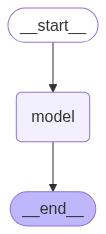

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(OverallState)

builder.add_node("model", node_1)

builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"messages": ["hi"]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='ac62858c-2b13-4178-9c4e-a97d2f2c09d5'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bio8RECh14Aai5hwhBg4MVYDSzkT9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b5fdbd0d-0c6b-4e95-b5a6-cbc2ae6693de-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Sample reAct Agent

In [11]:
def add(a: int, b: int) -> int:
    """Add a and b

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a, so (a - b)

    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> int:
    """Divide a by b

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)

In [31]:
from langchain_core.messages import HumanMessage, SystemMessage

sys_message = SystemMessage(content="You are an assistant that is tasked with performing basic four function math calculations. Take the expression given to you and find the smallest expression that you can calculate with the given numbers. Calculate that expression ONLY then get the value, then try to find the next smallest expression you can calculate and repeat. Do not perform multiple tool calls before getting responses for preceeding ones, one tool call at a time and get a response from a tool call before issuing another one.")

def model_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state["messages"])]}

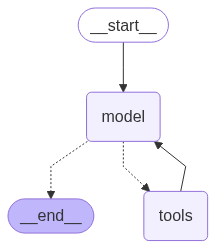

In [32]:
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(OverallState)

builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)

builder.add_edge("tools", "model")

react_model = builder.compile()

display(Image(react_model.get_graph(xray=True).draw_mermaid_png()))

In [35]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer = memory)

config = {"configurable": {"thread_id": 1}}

message = [HumanMessage(content="Add 3 and 12, and multiply that by 2 and divide the entire thing by 10, then finally subtract 10")]

messages = react_graph_memory.invoke({"messages": message}, config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 12, and multiply that by 2 and divide the entire thing by 10, then finally subtract 10
================================== Ai Message ==================================
Tool Calls:
  add (call_tS65kIFYImzbBQUEUXCPIRli)
 Call ID: call_tS65kIFYImzbBQUEUXCPIRli
  Args:
    a: 3
    b: 12
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KHQEfoRWOJJ36fwTv6He9RZn)
 Call ID: call_KHQEfoRWOJJ36fwTv6He9RZn
  Args:
    a: 15
    b: 2
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================
Tool Calls:
  divide (call_bsVdcO42keHIrdRObKoYJBIq)
 Call ID: call_bsVdcO42keHIrdRObKoYJBIq
  Args:
    a: 30
    b: 10
=======================

## PDF Image Extraction

In [7]:
import fitz
import io
from PIL import Image
import os

file = "./ai_agent_notes.pdf"

pdf_file = fitz.open(file)

for page_index in range(len(pdf_file)):
    page = pdf_file.load_page(page_index)
    image_list = page.get_images(full = True)

    if image_list:
        print(f"Found {len(image_list)} images on page {page_index}")
    else:
        print(f"No images on page {page_index}")

    for image_index, img in enumerate(image_list, start = 1):
        xref = img[0]
        
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]

        image_ext = base_image["ext"]

        image_name = f"image{page_index + 1}_{image_index}.{image_ext}"
        image_path = os.path.join("images", image_name)

        with open(image_path, "wb") as image_file:
            image_file.write(image_bytes)
            print(f"Image saved as {image_name}")

No images on page 0
No images on page 1
Found 4 images on page 2
Image saved as image3_1.png
Image saved as image3_2.png
Image saved as image3_3.png
Image saved as image3_4.png
Found 1 images on page 3
Image saved as image4_1.png
No images on page 4
No images on page 5
No images on page 6
No images on page 7
No images on page 8
No images on page 9
No images on page 10
No images on page 11
No images on page 12
No images on page 13
No images on page 14
No images on page 15
No images on page 16
No images on page 17
No images on page 18
No images on page 19
No images on page 20
No images on page 21
No images on page 22
No images on page 23
No images on page 24
No images on page 25
No images on page 26
No images on page 27
No images on page 28
No images on page 29
No images on page 30
No images on page 31
Found 1 images on page 32
Image saved as image33_1.png
No images on page 33
No images on page 34
No images on page 35
No images on page 36
No images on page 37
No images on page 38
No imag